In [0]:
!unzip attention.zip

Archive:  attention.zip
  inflating: attention.py            


In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline
from nltk.corpus import stopwords
from gensim.scripts.glove2word2vec import glove2word2vec
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout,MaxPooling1D,Conv1D,Dense,LSTM,Dropout,multiply,Embedding,Concatenate,Input,Bidirectional,TimeDistributed
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from attention import AttentionLayer
from keras import backend as K 
from datetime import datetime
from tensorflow import keras

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install ftfy

     |████████████████████████████████| 61kB 4.8MB/s 
  Created wheel for ftfy: filename=ftfy-5.7-cp36-none-any.whl size=44593 sha256=35a2c77a50de87df517e4eb3be30e85e3ff5b58fcd9c6c209a7d84f491634bdf
  Stored in directory: /root/.cache/pip/wheels/8e/da/59/6c8925d571aacade638a0f515960c21c0887af1bfe31908fbf
Successfully built ftfy


In [0]:
ne="Zozibini Tunzi from South Africa has been crowned Miss Universe 2019 at the finale which was held in Atlanta, Georgia, US on Monday. Puerto Rico's Madison Anderson was named the first runner-up while Sofía Aragón from Mexico stood third at the pageant. India was represented by 26-year-old Vartika Singh, who couldn't qualify for top 10"

In [0]:
df=pd.DataFrame()

In [0]:
df = df.append({'news': ne}, ignore_index=True)

In [0]:
import ftfy
from tqdm import tqdm_notebook
news = []
for i in tqdm_notebook(df.news):
    title = ftfy.fix_text(i)
    news.append(title)

In [0]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you'
"you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he'
'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its',
'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have','had','as',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because'
'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into'
'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on',
'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than'
's', 't', 'can', 'will', 'just','would']

In [0]:
import re
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase
  
from tqdm import tqdm_notebook
preprocessed2 = []
# tqdm is for printing the status bar
for sentance in tqdm_notebook(df['news'].values):
  sent = decontracted(sentance)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
  sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
  preprocessed2.append(sent.lower().strip())
df['news']=preprocessed2

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
s=Tokenizer()
h=Tokenizer()

In [0]:
import pickle

with open('/content/drive/My Drive/2_word_index.pickle', 'rb') as handle:
   s.word_index  = pickle.load(handle)

with open('/content/drive/My Drive/2_word_index_h.pickle', 'rb') as handle:
   h.word_index  = pickle.load(handle)
 

In [0]:
with open('/content/drive/My Drive/2_index_word.pickle', 'rb') as handle:
    s.index_word = pickle.load(handle) 

with open('/content/drive/My Drive/2_index_word_h.pickle', 'rb') as handle:
    h.index_word = pickle.load(handle)

In [0]:
X_test=df['news'].values

In [0]:
vocab_size = len(s.word_index) + 1 # for index zero we have to add +1  
encoded_docs_test = s.texts_to_sequences(X_test)
max_length = 70
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

In [0]:
y_vocab_size = len(h.word_index) + 1


In [0]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/213609%2F464671%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1591012919&Signature=kB84eyomS%2BeCmatiYxl9E7o%2BVGPkC4sawDoq%2Bpiml2PTNq0X8wI7PFAt2cqKrDWG0vmuqhbxd60w5ZSg%2FmMF0qVg8cJVVuFi06cFhm3qHkXjNIyCXsNJE4YOdzoasnJ7rELXN99CbnGJmtatKVR4QHH%2Fp9Tut1Ot%2Bsa%2FaSVYl0yc8I%2FS89NYG1nbsrJRJx4Yx9dAYPMqDTvvo0RUI5USacVMuVEb1SWjNYZv%2FYr%2B1DjJ2ZhJOgr3NUe6v1DcP1qx2gBjAAq3AoBO8jJKNCMtQ9N48LJA9J82jdF%2BZcg%2BNhBxoMOXsD%2Bv%2BVOwaZ%2FbCwIfP8VFauXjew7TA31%2FMysiEA%3D%3D" -c -O '213609_464671_bundle_archive.zip'

--2020-05-31 03:48:11--  https://storage.googleapis.com/kaggle-data-sets/213609%2F464671%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1591012919&Signature=kB84eyomS%2BeCmatiYxl9E7o%2BVGPkC4sawDoq%2Bpiml2PTNq0X8wI7PFAt2cqKrDWG0vmuqhbxd60w5ZSg%2FmMF0qVg8cJVVuFi06cFhm3qHkXjNIyCXsNJE4YOdzoasnJ7rELXN99CbnGJmtatKVR4QHH%2Fp9Tut1Ot%2Bsa%2FaSVYl0yc8I%2FS89NYG1nbsrJRJx4Yx9dAYPMqDTvvo0RUI5USacVMuVEb1SWjNYZv%2FYr%2B1DjJ2ZhJOgr3NUe6v1DcP1qx2gBjAAq3AoBO8jJKNCMtQ9N48LJA9J82jdF%2BZcg%2BNhBxoMOXsD%2Bv%2BVOwaZ%2FbCwIfP8VFauXjew7TA31%2FMysiEA%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928408067 (1.8G) [application/zip]
Saving to: ‘213609_464671_bundle_archive.zip’

213609_464671_bundl 100%[===================>]   1.80G  70.6MB/s    in 28s

In [0]:
!unzip /content/213609_464671_bundle_archive.zip

Archive:  /content/213609_464671_bundle_archive.zip
  inflating: glove.42B.300d.txt      


In [0]:
from numpy import asarray
from tqdm import tqdm_notebook
embeddings_index = dict()
f = open('glove.42B.300d.txt')
for line in tqdm_notebook(f):
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [0]:
from numpy import zeros
input_matrix = zeros((vocab_size, 300))
for word, i in tqdm_notebook(s.word_index.items()):
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    input_matrix[i] = embedding_vector

In [0]:
from numpy import zeros
decoder_matrix = zeros((y_vocab_size, 300))
for word, i in tqdm_notebook(h.word_index.items()):
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    decoder_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.models import model_from_json

json_file = open('/content/drive/My Drive/model_gen_h.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json, {'AttentionLayer': AttentionLayer})
loaded_model.load_weights("/content/drive/My Drive/model_gen_h.h5")
print("Loaded model from disk")
 

Loaded model from disk


In [0]:
news_word_index=s.index_word
headlines_word_index=h.index_word
target_headlines_word_index=h.word_index

In [0]:
encoder_input = loaded_model.input[0]

In [0]:
state_h=loaded_model.layers[5].output
state_c=loaded_model.layers[6].output


In [0]:
encoder_out,f_h_out,f_cell_out,b_h_out,b_cell_out = loaded_model.layers[3].output

In [0]:
encoder_model = Model(inputs=encoder_input,outputs=[encoder_out, state_h, state_c])

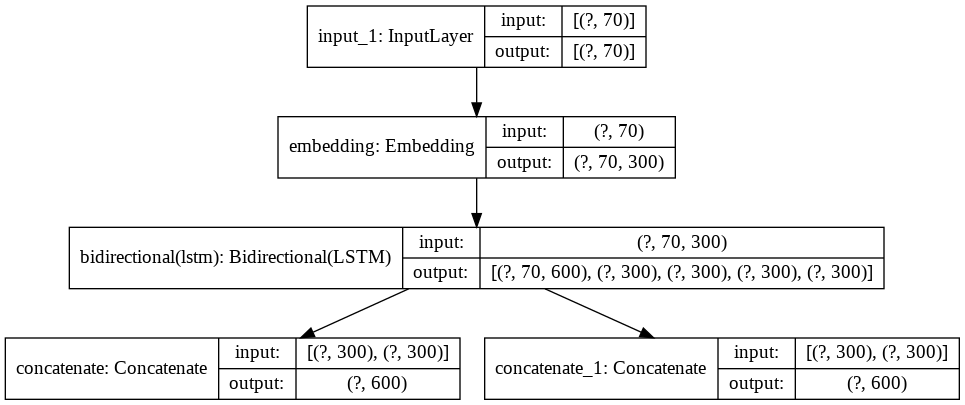

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(encoder_model, to_file='model.png', show_shapes=True)

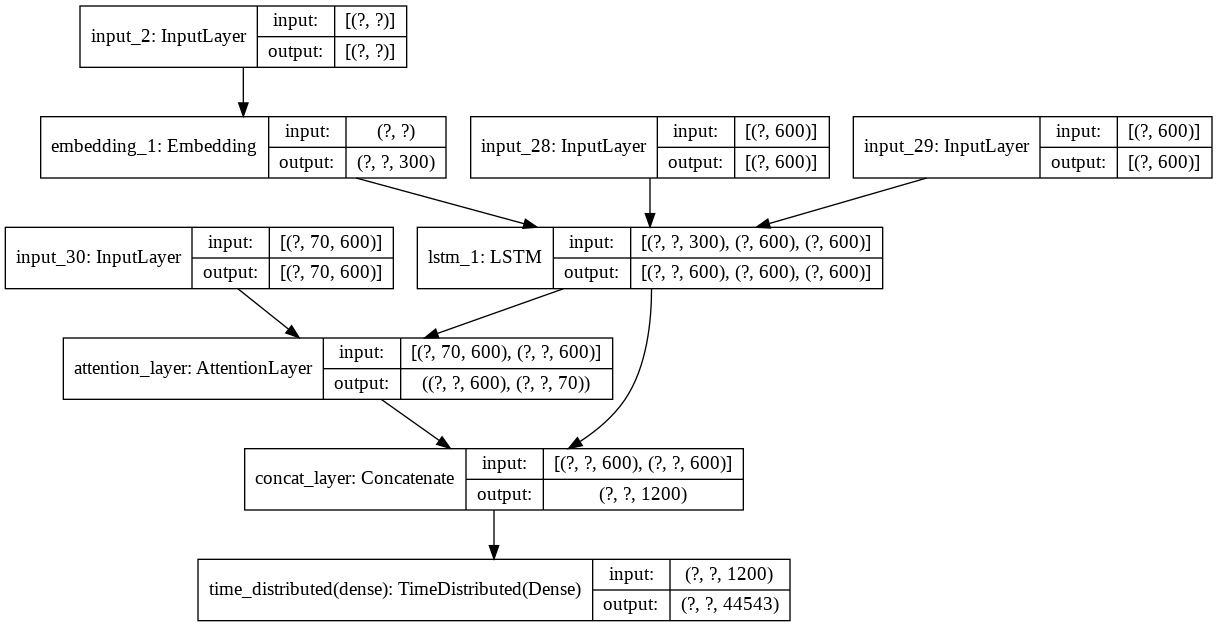

In [0]:
decoder_input_h = Input(shape=(600,))
decoder_input_c = Input(shape=(600,))
decoder_hidden_state = Input(shape=(70,600))
decoder_input = loaded_model.layers[2].output
dec_emb2 = loaded_model.layers[4].output
decoder_outputs2, state_h2, state_c2 = loaded_model.layers[7](dec_emb2,initial_state=[decoder_input_h,decoder_input_c])
attn_out_inf, attn_states_inf = loaded_model.layers[8]([decoder_hidden_state,decoder_outputs2])
decoder_inf_concat = loaded_model.layers[9]([decoder_outputs2,attn_out_inf])
decoder_outputs2 = loaded_model.layers[10](decoder_inf_concat)
decoder_model = Model(
    [decoder_input] + [decoder_hidden_state,decoder_input_h, decoder_input_c],[decoder_outputs2] + [state_h2,state_c2])
plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [0]:
#https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
#https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    seq[0, 0] = target_headlines_word_index['ssttaarrtt']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
      
        output, h, c = decoder_model.predict([seq] + [e_out, e_h, e_c])
        
        token_index = np.argmax(output[0, -1, :])
        try:
          token = headlines_word_index[token_index]
                          
          if(token!='eenndd'):
            decoded_sentence += ' '+token

        # Exit condition: either hit max length or find stop word.
          if (token == 'eenndd'  or len(decoded_sentence.split()) >= (20-1)):
            stop_condition = True
        except:
          pass
        # Update the target sequence (of length 1).
        seq = np.zeros((1,1))
        seq[0, 0] = token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def headlines(input_seq):
    s=''
    for i in input_seq:
        if((i!=0 and i!=target_headlines_word_index['ssttaarrtt']) and i!=target_headlines_word_index['eenndd']):
            s=s+headlines_word_index[i]+' '
    return s

def news(input_seq):
    s=''
    
    for i in input_seq:
        if(i!=0):
            s=s+news_word_index[i]+' '
    return s


In [0]:
decode_sequence(padded_docs_test[0].reshape(1,70))

' south africa zozibini tunzi crowned miss universe 2019'